In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [2]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                      exception_only=False, running_compiled_code=False):
       etype, value, tb = sys.exc_info()
       return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

In [3]:
fname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_final'}.xlsx")
cname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_case'}.xlsx")
lname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_law'}.xlsx")

dff = pd.read_excel(fname, index_col=0)
dfc = pd.read_excel(cname, index_col=0)
dfl = pd.read_excel(lname, index_col=0)

#df = pd.concat([dff[['h1_age', 'h1_sex', 'h2_age', 'h2_sex', 'h3_age', 'h3_sex', 'text', 'y_appeal']], dfc[1:], dfl[1:]], axis=1).reindex(dff.index)
df = pd.concat([dff[['text', 'y_appeal']], dfc[1:], dfl[1:]], axis=1).reindex(dff.index)
df = df.dropna(subset=['y_appeal'])

In [4]:
df_0 = df[df['y_appeal'] == 0].sample(frac=1)
df_1 = df[df['y_appeal'] == 1].sample(frac=1)

sample_size = 470

df = pd.concat([df_0.head(sample_size), df_1.head(sample_size)]).sample(frac=1)

In [5]:
X = df.drop('y_appeal', axis=1)
y = tf.keras.utils.to_categorical(df['y_appeal'])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [7]:
X1_train = X_train[dfc.columns[1:]]
X1_test = X_test[dfc.columns[1:]]

X2_train = X_train[dfl.columns[1:]]
X2_test = X_test[dfl.columns[1:]]

#X4_train =  X_train[['h1_age', 'h1_sex', 'h2_age', 'h2_sex', 'h3_age', 'h3_sex']]
#X4_test =  X_test[['h1_age', 'h1_sex', 'h2_age', 'h2_sex', 'h3_age', 'h3_sex']]

In [8]:
X3_train = list(X_train["text"])
X3_test = list(X_test["text"])

max_features = 30000
sequence_length = 128

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(X3_train)

X3_train = tokenizer.texts_to_sequences(X3_train)
X3_test = tokenizer.texts_to_sequences(X3_test)

X3_train = tf.keras.preprocessing.sequence.pad_sequences(X3_train, sequence_length)
X3_test = tf.keras.preprocessing.sequence.pad_sequences(X3_test, sequence_length)

In [9]:
input_1 = tf.keras.Input(dtype = tf.float32, shape = (529,))
input_2 = tf.keras.Input(dtype = tf.float32, shape = (662,))
#input_4 = tf.keras.Input(dtype = tf.float32, shape = (6,))

dense_layer_1_1 = tf.keras.layers.Dense(units = 50, activation = tf.nn.relu)(input_1)
dense_layer_1_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_1)
dense_layer_1_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_2)
dense_layer_1_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_3)
dropout_1_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_1_4)


dense_layer_2_1 = tf.keras.layers.Dense(units = 50, activation = tf.nn.relu)(input_2)
dense_layer_2_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_1)
dense_layer_2_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_2)
dense_layer_2_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_3)
dropout_2_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_2_4)


#dense_layer_4_1 = tf.keras.layers.Dense(units = 50, activation = tf.nn.relu)(input_4)
#dense_layer_4_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4_1)
#dense_layer_4_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4_2)
#dense_layer_4_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4_3)
#dropout_4_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_4_4)

In [10]:
embeddings_index = {}
f = open(os.path.join(os.path.dirname(os.getcwd()), 'data_processing', 'ft_0814t.txt'),  encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

word_index = tokenizer.word_index

num_words = min(max_features, len(word_index)) + 1
print(num_words)
embedding_dim = 128
num_filters = 100

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

12653


In [11]:
input_3 = tf.keras.Input(dtype = tf.float32, shape = (sequence_length,))
embedding_layer_3 = tf.keras.layers.Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(input_3)

reshape_3 = tf.keras.layers.Reshape((sequence_length, embedding_dim, 1))(embedding_layer_3)

conv_0_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)
conv_1_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)
conv_2_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)

maxpool_0_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_3)
maxpool_1_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_3)
maxpool_2_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_3)

concatenated_tensor_3 = tf.keras.layers.Concatenate(axis=1)([maxpool_0_3, maxpool_1_3, maxpool_2_3])
flatten_3 = tf.keras.layers.Flatten()(concatenated_tensor_3)
dropout_3 = tf.keras.layers.Dropout(rate = 0.5)(flatten_3)

In [12]:
#concat_layer = tf.keras.layers.Concatenate()([dropout_1_5, dropout_2_5, dropout_3, dropout_4_5])
concat_layer = tf.keras.layers.Concatenate()([dropout_1_5, dropout_2_5, dropout_3])

dense_layer_3 = tf.keras.layers.Dense(units = 50, activation = tf.nn.relu)(concat_layer)
dense_layer_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_3)
dense_layer_5 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4)
dense_layer_6 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_5)

output = tf.keras.layers.Dense(units = 2, activation = tf.nn.softmax)(dense_layer_5)

#model = tf.keras.Model(inputs=[input_1, input_2, input_3, input_4], outputs=output)
model = tf.keras.Model(inputs=[input_1, input_2, input_3], outputs=output)

In [13]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005), metrics=['acc'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 128, 128)     1619584     input_3[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 529)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 662)]        0                                            
______________________________________________________________________________________________

In [14]:
#history = model.fit(x=[X1_train, X2_train, X3_train, X4_train], y=y_train, batch_size=2, epochs=100, verbose=1, validation_split=0.1)
history = model.fit(x=[X1_train, X2_train, X3_train], y=y_train, batch_size=2, epochs=100, verbose=1, validation_split=0.1)

Train on 761 samples, validate on 85 samples
Epoch 1/100
761/761 [==============================] - 3s 4ms/sample - loss: 7.7190 - acc: 0.5125 - val_loss: 2.5036 - val_acc: 0.4471
Epoch 2/100
761/761 [==============================] - 1s 2ms/sample - loss: 1.4079 - acc: 0.5611 - val_loss: 0.8793 - val_acc: 0.6824
Epoch 3/100
761/761 [==============================] - 1s 2ms/sample - loss: 0.7681 - acc: 0.6005 - val_loss: 0.7178 - val_acc: 0.4588
Epoch 4/100
761/761 [==============================] - 1s 2ms/sample - loss: 0.7010 - acc: 0.6045 - val_loss: 0.6973 - val_acc: 0.4941
Epoch 5/100
761/761 [==============================] - 1s 2ms/sample - loss: 0.6915 - acc: 0.6386 - val_loss: 0.6889 - val_acc: 0.6588
Epoch 6/100
761/761 [==============================] - 1s 2ms/sample - loss: 0.6899 - acc: 0.6399 - val_loss: 0.6844 - val_acc: 0.8000
Epoch 7/100
761/761 [==============================] - 1s 2ms/sample - loss: 0.6864 - acc: 0.6846 - val_loss: 0.6857 - val_acc: 0.7059
Epoch 8/10

761/761 [==============================] - 2s 2ms/sample - loss: 0.6320 - acc: 0.8463 - val_loss: 0.5882 - val_acc: 0.8941
Epoch 61/100
761/761 [==============================] - 2s 2ms/sample - loss: 0.6030 - acc: 0.8607 - val_loss: 0.5676 - val_acc: 0.8824
Epoch 62/100
761/761 [==============================] - 2s 2ms/sample - loss: 0.5770 - acc: 0.8449 - val_loss: 0.5480 - val_acc: 0.9294
Epoch 63/100
761/761 [==============================] - 2s 2ms/sample - loss: 0.5671 - acc: 0.8633 - val_loss: 0.5184 - val_acc: 0.8824
Epoch 64/100
761/761 [==============================] - 2s 2ms/sample - loss: 0.5408 - acc: 0.8739 - val_loss: 0.4754 - val_acc: 0.9059
Epoch 65/100
761/761 [==============================] - 2s 2ms/sample - loss: 0.5034 - acc: 0.8791 - val_loss: 0.4873 - val_acc: 0.9176
Epoch 66/100
761/761 [==============================] - 2s 2ms/sample - loss: 0.5212 - acc: 0.8594 - val_loss: 0.4750 - val_acc: 0.9059
Epoch 67/100
761/761 [==============================] - 2s 2m

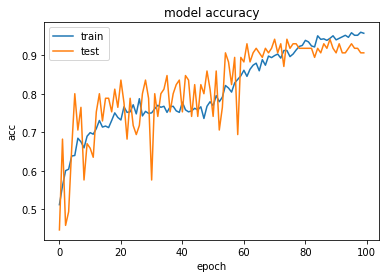

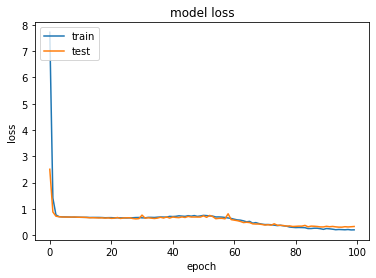

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [16]:
#score = model.evaluate(x=[X1_test, X2_test, X3_test, X4_test], y=y_test, verbose=1)
score = model.evaluate(x=[X1_test, X2_test, X3_test], y=y_test, verbose=1)

print("Test Score:", score[0])
print("Test ACC:", score[1])

94/94 [==============================] - 0s 2ms/sample - loss: 0.3262 - acc: 0.8936
Test Score: 0.32619511573872667
Test ACC: 0.89361703


In [17]:
#tf-idf 0.2
# 50-10-10-10-10 배치 2, 에폭 100, 0.01: 93 91 92// 60 55 52 55 53 52
# 50-10-10-10-10 배치 2, 에폭 100, 0.001: 73 73 76 72 72
# 50-10-10-10-10 배치 2, 에폭 100, 0.005: 90 65 91 87 52// 59 55 91 51 87 //48 50 94 81 56 // 82 94 53 54 58 => 70
# 50-10-10-10-10 배치 2, 에폭 100, 0.002: 60 90 93 59 63// 89 72 57 59 89 // 87 67 59 70 85 // 57 60 68 90 67 => 72

# 50-10-10-10-10 배치 2, 에폭 100, 0.0005: 74 91 88 76 88 // 75 77 90 92 71 // 76 90 93 79 76// 73 72 76 76 77 => 80
# 50-10-10-10-10 배치 4, 에폭 100, 0.0005: 79 70 74 78 76 // 82 72 84 78 77 // 85 75 77 84 77
# 50-10-10-10-10 배치 8, 에폭 100, 0.0005: 78 79 72 78 75 // 75 73 81 81 65
# 50-10-10-10-10 배치 16, 에폭 100, 0.0005: 81 75 76 69 77 // 

# 100-100-100-100-100 배치 2, 에폭 100, 0.0005: 69 95 93 76 79 // 73 94 79 75 77 // 78 70 75 60 88 // 69 92 88 86 74 => 79
# 10-10-10-10-10 배치 2, 에폭 100, 0.0005: 75 82 75 82 75 // 73 74 65 75 85
# 100-10-10-10-10 배치 2, 에폭 100, 0.0005: 86 85 80 72 78 // 96 84 73 65 79 // => 80

# 50-10-10-10-10 배치 2, 에폭 200, 0.0005: 72
# 50-10-10-10-10 배치 2, 에폭 100, 0.0005, random: 89 89 88 89 87 //89 88 88 89 89 
# 50-10-10-10-10 배치 2, 에폭 150, 0.0005, random: 87 87 87
# 50-10-10-10-10 배치 2, 에폭 200, 0.0005, random: 86 85 

# 50-10-10-10-10 배치 2, 에폭 100, 0.0005, random, w2v: 88 88 88

# 50-10-10-10 배치 2, 에폭 100, 0.0005, random, 판사없이: 90 88 89 89 89 // 88 89 
# 100-100-100-100 배치 2, 에폭 100, 0.0005, random, 판사없이: 85 
# 100-10-10-10 배치 2, 에폭 100, 0.0005, random, 판사없이: 88
# 8-8-8-8 배치 2, 에폭 100, 0.0005, random, 판사없이: 88
# 10-10-10-10 배치 2, 에폭 100, 0.0005, random, 판사없이: 87



# 50-10-10-10-10 배치 2, 에폭 100, 0.0001: 80 72 81 72 77 // 77 75 80 85 68 // 75
# 50-10-10-10-10 배치 2, 에폭 100, 0.00005: 85 80 75 77 73// 73 

# 50-10-10-10-10 배치 2, 에폭 100, 0.02: 51 50 53 54 45 56 54

#tf-idf 0.1
#50-10-10-10 배치 2, 에폭 100, 0.0005, random, 판사없이: 82



# 50-10-10-10/10-10 배치 2, 에폭 100, 0.0005, random, 판사없이: 87 87
# 50-10-10-10/10-10-10 배치 2, 에폭 100, 0.0005, random, 판사없이: 90 90 89 90 89 90 89 
# 50-10-10-10/10-10-10-10 배치 2, 에폭 100, 0.0005, random, 판사없이: 88 89
